
# Flow Matching for Swiss Roll Data

In this notebook, we apply the flow matching methodology to learn a transport map between a simple base distribution and a target Swiss Roll distribution.

**Key Ideas:**
- **Training Objective:**  
  Given a pair of samples $x_0 \sim \mathcal{N}(0, I)$ (base) and $x_1 \sim p_{\text{data}}$ (target), we compute a linear interpolation  
$$
  x_t = (1-t)\,x_0 + t\,x_1,\quad t \in [0,1],
$$
  and define the ground-truth velocity field as:
$$
  v_{\text{target}} = x_1 - x_0.
$$
  The network takes as input $(x_t,t)$ and is trained to predict $v(x_t,t) \approx v_{\text{target}}$.

- **Sampling:**  
  Once trained, we can generate samples from the target distribution by starting from a sample \(x_0 \sim \mathcal{N}(0,I)\) and integrating the ODE:
  $$
  \frac{dx}{dt} = v(x,t),
  $$
  from $t=0$ to $t=1$.

**Your Tasks:**
- Study all code cells and comments.
- Experiment with the integration (try improving the Euler solver).
- Compare with the corresponding diffusion model (which uses a noise‐removal objective rather than direct flow matching).


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)


## Data Generation

We define two helper functions:
1. `generate_swiss_roll`: Generates target Swiss Roll data (in $\mathbb{R}^2$).
2. `sample_gaussian`: Samples from the base Gaussian distribution.

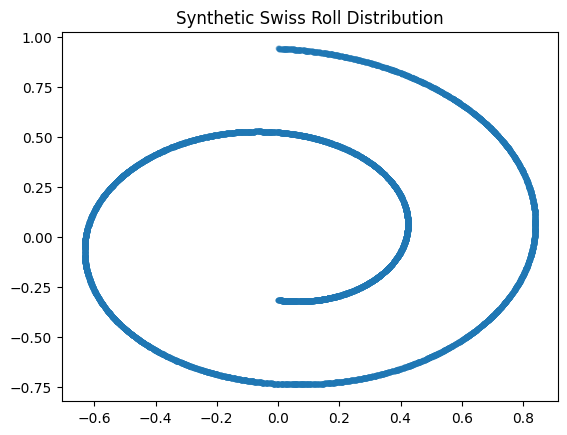

In [ ]:
def generate_swiss_roll(n_samples=1000, device='cpu'):
    """
    Generate 2D Swiss Roll data points.

    Args:
        n_samples: Number of points.
        device: Device to place the tensor.

    Returns:
        Tensor of shape (n_samples, 2).
    """
    t = 1.5 * np.pi * (1 + 2 * torch.rand(n_samples))
    x = t * torch.cos(t)
    y = t * torch.sin(t)
    data = torch.stack([x, y], dim=1) / 15.0  # Scale down the data
    return data.to(device)

# Function to sample from a base Gaussian distribution.
def sample_gaussian(n_samples, device='cpu'):
    return torch.randn(n_samples, 2, device=device)

# Visualize the target Swiss Roll:
data = generate_swiss_roll(n_samples=10000)
plt.scatter(data[:, 0].cpu(), data[:, 1].cpu(), alpha=0.5, s=10)
plt.title("Synthetic Swiss Roll Distribution")
plt.show()


## Flow Matching Network Architecture

This network takes as input a 2D point $x \in \mathbb{R}^2$ and a scalar time $t$ (reshaped to $\mathbb{R}^1$).  
It outputs a 2D velocity $v(x,t) \in \mathbb{R}^2$.

The network architecture is a simple MLP.

**Note:** You might experiment with additional layers, activations, or even different network architectures.


In [ ]:
class FlowMatchingNet(nn.Module):
    def __init__(self, in_dim=3, hidden_dim=128, out_dim=2):
        """
        Args:
            in_dim: Dimensionality of the input (2 for x and 1 for t).
            hidden_dim: Hidden layer dimension.
            out_dim: Dimensionality of the output (2 for velocity).
        """
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, out_dim)
        )

    def forward(self, x, t):
        # x has shape (B, 2) and t has shape (B, 1). Concatenate them along dimension 1.
        xt = torch.cat([x, t], dim=1)
        return self.net(xt)


## Training the Flow Matching Model

We now train the network using the flow matching objective.

**Procedure:**
1. Sample a random time $t \sim U(0,1)$ for each data point.
2. Sample $x_0$ from the base Gaussian and $x_1$ from the Swiss Roll.
3. Compute the linear interpolation:
   $$
   x_t = (1-t)x_0 + t x_1.
   $$
4. Define the ground-truth velocity as:
   $$
   v_{\text{target}} = x_1 - x_0.
   $$
5. Compute the network's prediction $v_{\text{pred}} = v(x_t,t)$.
6. Compute the mean squared error between $v_{\text{pred}}$ and $v_{\text{target}}$.

**TODO:** You may experiment with modifying the training loop (e.g., change the number of steps, batch size, or learning rate).

In [ ]:
def train_flow_matching(net, optimizer, num_steps=10000, batch_size=512, device='cpu'):
    """
    Train the flow matching network.

    Args:
        net: The FlowMatchingNet.
        optimizer: Optimizer for training.
        num_steps: Number of training steps.
        batch_size: Batch size.
        device: Device to use.
    """
    for step in range(num_steps):
        # Sample a batch of times uniformly in [0, 1]
        t = torch.rand(batch_size, 1, device=device)
        # Sample x0 (base) and x1 (target) from their respective distributions.
        x0 = sample_gaussian(batch_size, device=device)
        x1 = generate_swiss_roll(batch_size, device=device)

        # Compute the linear interpolation:
        #   x_t = (1-t) * x0 + t * x1.
        x_t = (1 - t) * x0 + t * x1

        # The ground-truth velocity is constant along the interpolation:
        v_target = x1 - x0

        # Network prediction: velocity given x_t and t.
        v_pred = net(x_t, t)

        # Compute mean squared error loss.
        loss = ((v_pred - v_target) ** 2).mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if step % 500 == 0:
            print(f"Step {step}, Loss: {loss.item():.6f}")

    print("Training completed.")

# Initialize network and optimizer.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = FlowMatchingNet().to(device)
optimizer = optim.Adam(net.parameters(), lr=1e-3)

# Train the flow matching network.
train_flow_matching(net, optimizer, num_steps=20000, batch_size=256, device=device)

Step 0, Loss: 1.102638
Step 500, Loss: 0.644904
Step 1000, Loss: 0.601848
Step 1500, Loss: 0.673120
Step 2000, Loss: 0.688394
Step 2500, Loss: 0.677431
Step 3000, Loss: 0.711405
Step 3500, Loss: 0.581088
Step 4000, Loss: 0.673047
Step 4500, Loss: 0.584574
Step 5000, Loss: 0.563341
Step 5500, Loss: 0.743910
Step 6000, Loss: 0.675456
Step 6500, Loss: 0.699538
Step 7000, Loss: 0.553221
Step 7500, Loss: 0.705337
Step 8000, Loss: 0.600472
Step 8500, Loss: 0.649899
Step 9000, Loss: 0.625142
Step 9500, Loss: 0.557820
Step 10000, Loss: 0.665037
Step 10500, Loss: 0.678468
Step 11000, Loss: 0.665058
Step 11500, Loss: 0.661184
Step 12000, Loss: 0.641925
Step 12500, Loss: 0.622822
Step 13000, Loss: 0.599991
Step 13500, Loss: 0.638961
Step 14000, Loss: 0.695556
Step 14500, Loss: 0.629281
Step 15000, Loss: 0.604185
Step 15500, Loss: 0.657501
Step 16000, Loss: 0.592283
Step 16500, Loss: 0.653349
Step 17000, Loss: 0.621995
Step 17500, Loss: 0.578182
Step 18000, Loss: 0.598404
Step 18500, Loss: 0.63350


## Sampling from the Learned Flow

To generate new samples from the target distribution we simulate the ODE:
$$
\frac{dx}{dt} = v(x,t),
$$
using Euler integration. We start from a base sample $x(0) \sim \mathcal{N}(0,I)$ at $t=0$ and
integrate from $t=0$ to $t=1$.

**TODO:** Experiment with a more advanced solver (e.g., Runge-Kutta) to see if the sample quality improves.

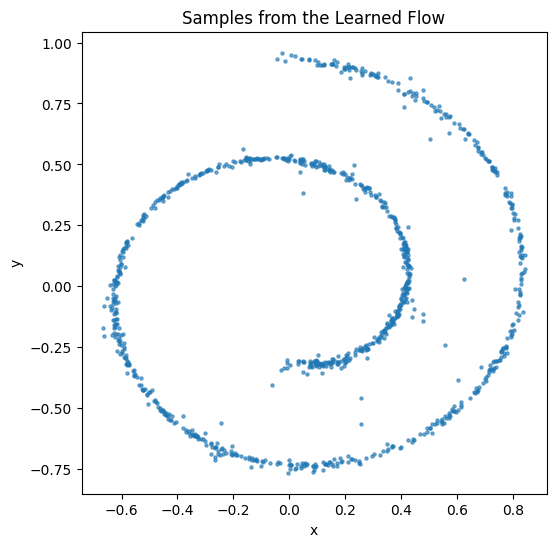

In [ ]:
# %% [code]
def sample_from_flow(net, num_samples=1000, num_steps=100, device='cpu'):
    """
    Generate samples using the learned flow.

    Args:
        net: The trained FlowMatchingNet.
        num_samples: Number of samples to generate.
        num_steps: Number of integration steps.
        device: Device to use.

    Returns:
        Tensor of shape (num_samples, 2).
    """
    dt = 1.0 / num_steps  # Time step for Euler integration.
    # Start from the base distribution.
    x = sample_gaussian(num_samples, device=device)

    # Integrate forward in time from t=0 to t=1.
    for step in range(num_steps):
        # Current time (scalar) and expand to a (num_samples,1) tensor.
        t = (step * dt) * torch.ones(num_samples, 1, device=device)
        # Compute the velocity via the network.
        v = net(x, t)
        # Euler update: x_{t+dt} = x_t + dt * v(x_t, t)
        # x = x + dt * v

        # TODO: Replace the Euler update with a Runge-Kutta 4 (RK4) integration method.
        # For RK4, compute:
        #   k1 = dt * v(x, t)
        #   k2 = dt * v(x + 0.5*k1, t + 0.5*dt)
        #   k3 = dt * v(x + 0.5*k2, t + 0.5*dt)
        #   k4 = dt * v(x + k3, t + dt)
        # Then update: x = x + (k1 + 2*k2 + 2*k3 + k4) / 6
        # This is left as an exercise to better understand numerical ODE solvers.
        k1 = dt * v
        k2 = dt * net(x + 0.5 * k1, t + 0.5 * dt)
        k3 = dt * net(x + 0.5 * k2, t + 0.5 * dt)
        k4 = dt * net(x + k3, t + dt)
        x = x + (k1 + 2 * k2 + 2 * k3 + k4) / 6
    return x

# Generate samples using the learned flow.
samples_flow = sample_from_flow(net, num_samples=1000, num_steps=100, device=device)
samples_flow = samples_flow.detach().cpu().numpy()

# Plot the generated samples.
plt.figure(figsize=(6,6))
plt.scatter(samples_flow[:, 0], samples_flow[:, 1], s=5, alpha=0.6)
plt.title("Samples from the Learned Flow")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

## Comparing Flow Matching and Diffusion Objectives

In the flow matching framework, the network is trained to predict a *constant* velocity field $x_1-x_0$ along the interpolant.
In diffusion models, the network is instead trained to predict the noise added at each time step (with time‐dependent schedules).

**Your Tasks:**
- Compare sample quality between flow matching and diffusion approaches.
- Experiment with different training settings in either framework.
- Reflect on advantages and limitations of each approach for generative modeling.

Happy experimenting!

## **Answer**

Flow matching generates samples that are closer to the real Swiss roll structure, with higher fidelity and less noise, while diffusion produces more scattered and noisy samples, capturing the general shape but with lower precision.


Diffusion Models:

Advantages:

* Robust to noise and capable of generating diverse samples.

* Flexible and effective for high-dimensional data.

* Well-suited for image generation tasks.

Limitations:

* Computationally expensive due to iterative sampling processes.

* Generated samples may lack sharpness or precision in simple datasets like Swiss rolls.

Flow Matching Models:

Advantages:

* Faster sampling process compared to diffusion models.

* Produces high-fidelity samples with sharp structures, as seen in the Swiss roll example.

* Efficient training dynamics with fewer iterations.

Limitations:

*   May struggle with highly complex or high-dimensional data distributions.
*   Requires careful tuning of network architecture and hyperparameters.






# Extra Resource for Reference

## Understanding Flow Matching

Imagine you're watching a cloud morph into a shape in the sky. The transformation happens smoothly - parts of the cloud gradually shift and move until the final shape emerges. Flow matching works in a similar way: it learns how to smoothly transform one distribution (like random noise) into another (like our desired data).

## Why Do We Need Flow Matching?

Traditional generative models can be tricky. GANs often have unstable training (imagine two artists constantly arguing about what makes a good painting), and VAEs might be lossy. Flow matching offers a more direct and stable approach.

## The Intuition Behind Flow Matching

1. Every point in our space has to move from its starting position (noise) to its final position (data)
2. We want these movements to be smooth and coordinated
3. At each moment, each point needs to know which direction to move

### The Mathematical Breakdown

Let's break this down step by step:

1. **The Velocity Field**: At each point in space and time, we need to know "which way to move":
   $$\frac{dx(t)}{dt} = v(x(t), t)$$
   This is like having a dance instructor at every spot in the room, telling dancers which way to move.

2. **The Path**: We use a simple linear path between start and end:
   $$x(t) = \alpha(t)x_0 + (1-\alpha(t))x_1$$
   
   Think of it like a rope between two points - as you move along the rope ($t$ going from 0 to 1), you smoothly go from one end to the other.

## How Do We Train This?

### The Learning Process

1. **Start Simple**: Begin with random noise (imagine scattered dots)
2. **Define the Goal**: Know what we want these dots to become (our Swiss Roll pattern)
3. **Learn the Flow**: Train a neural network to guide each point along its path

### The Training

For each training step:
1. Take some random points (noise)
2. Pick random moments in time
3. Figure out where points should be at those times
4. Teach our network to predict the right movements

Mathematically, we minimize:
$$\mathcal{L} = \mathbb{E}_{x_0,x_1,t}[\|v_\theta(x(t),t) - v^*(x,t)\|^2]$$


## Implementation Overview

In this tutorial, we'll:
1. Create a Swiss Roll pattern (our target distribution)
2. Build a neural network (our flow controller - tells every point which direction to move)
3. Train it to learn the right flow
4. Watch how points flow from noise to beautiful patterns!

Below, let's start by generating our Swiss Roll pattern...

## Key Papers for more details 📚

* Lipman (2023). "Flow Matching for Generative Modeling." ICLR 2023
* Chen et al. (2018). "Neural Ordinary Differential Equations." NeurIPS 2018
* Grathwohl et al. (2019). "FFJORD: Free-form Continuous Dynamics." ICLR 2019